In [117]:
#Importing libraries
!pip install opendatasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Defaulting to user installation because normal site-packages is not writeable


DATA CLEANING

In [118]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("sales_prediction.csv")

# Perform data cleaning operations

# Remove duplicates
df = df.drop_duplicates()

# Handling missing values
# For numerical columns, fill missing values with the mean
numerical_cols = df.select_dtypes(include='number').columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# For categorical columns, fill missing values with mode
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Example: Handling Item_Weight units (if inconsistent)
def standardize_weight(weight):
    if isinstance(weight, str):  # Check if weight is a string
        if 'kg' in weight:
            return float(weight.strip('kg')) * 1000  # Convert to grams
        else:
            return float(weight)  
    else: 
        return weight  # If it's already a number, return as it is

df['Item_Weight'] = df['Item_Weight'].apply(standardize_weight)

# Example: Fixing typos in Item_Type
df['Item_Type'].replace({'Frouts': 'Fruits', 'Vegtables': 'Vegetables'}, inplace=True)

# Remove outliers using Z-score method
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include='number'))
threshold = 3
df = df[(z_scores < threshold).all(axis=1)]



In [119]:
missing_percentages = df.isna().sum().sort_values(ascending=False) / len(df)
missing_percentages

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

DATA PREPROCESSING

In [120]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Medium,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [121]:
Item_Fat_Content = df.Item_Fat_Content.value_counts()
Item_Fat_Content

Low Fat    4989
Regular    2817
LF          307
reg         116
low fat     109
Name: Item_Fat_Content, dtype: int64

In [122]:
#since there in column Item_Fat_Content (Low Fat and low fat) & (Regular & reg) is same so we are changing the names
name_changes = {'reg': 'Regular', 'low fat': 'Low Fat'}

# Update the names in the 'Item_Fat_Content' column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(name_changes)

In [123]:
Item_Fat_Content = df.Item_Fat_Content.value_counts()
Item_Fat_Content

Low Fat    5098
Regular    2933
LF          307
Name: Item_Fat_Content, dtype: int64

In [124]:
Item_Type = df.Item_Type.value_counts()
Item_Type

Fruits and Vegetables    1201
Snack Foods              1169
Household                 896
Frozen Foods              838
Dairy                     655
Canned                    640
Baking Goods              637
Health and Hygiene        515
Soft Drinks               435
Meat                      417
Breads                    247
Hard Drinks               211
Others                    169
Starchy Foods             143
Breakfast                 104
Seafood                    61
Name: Item_Type, dtype: int64

In [125]:
Outlet_Size = df.Outlet_Size.value_counts()
Outlet_Size

Medium    5085
Small     2326
High       927
Name: Outlet_Size, dtype: int64

In [126]:
Outlet_Location_Type = df.Outlet_Location_Type.value_counts()
Outlet_Location_Type

Tier 3    3243
Tier 2    2768
Tier 1    2327
Name: Outlet_Location_Type, dtype: int64

In [127]:
Outlet_Type = df.Outlet_Type.value_counts()
Outlet_Type

Supermarket Type1    5547
Grocery Store         988
Supermarket Type2     928
Supermarket Type3     875
Name: Outlet_Type, dtype: int64

In [128]:
Outlet_Identifier = df.Outlet_Identifier.value_counts()
Outlet_Identifier

OUT018    928
OUT049    927
OUT013    927
OUT035    926
OUT046    925
OUT045    924
OUT017    918
OUT027    875
OUT010    513
OUT019    475
Name: Outlet_Identifier, dtype: int64

In [129]:
# Generate dummy variables for multiple columns
dummies = pd.get_dummies(df, columns=['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type','Outlet_Identifier','Outlet_Type','Outlet_Size'])

In [130]:
dummies.drop(['Item_Identifier', 'Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Item_Outlet_Sales'],axis='columns',inplace = True)

In [131]:
merged = pd.concat([df,dummies],axis = 'columns')
merged

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,0,0,1,0,1,0,0,0,1,0
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,0,0,0,0,0,1,0,0,1,0
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,0,0,1,0,1,0,0,0,1,0
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,...,0,0,0,1,0,0,0,0,1,0
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,...,0,0,0,0,1,0,0,1,0,0
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Medium,Tier 2,...,1,0,0,0,1,0,0,0,1,0
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,...,0,0,0,0,1,0,0,0,0,1
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,...,0,0,0,0,0,1,0,0,1,0


In [132]:
merged.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Ou

In [133]:
final = merged.drop(['Item_Fat_Content','Item_Type', 'Outlet_Location_Type','Outlet_Identifier','Outlet_Type','Outlet_Size'],axis = 'columns')

In [134]:
final

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
0,FDA15,9.300,0.016047,249.8092,1999,3735.1380,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
1,DRC01,5.920,0.019278,48.2692,2009,443.4228,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,FDN15,17.500,0.016760,141.6180,1999,2097.2700,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
3,FDX07,19.200,0.000000,182.0950,1998,732.3800,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,NCD19,8.930,0.000000,53.8614,1987,994.7052,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,0.056783,214.5218,1987,2778.3834,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
8519,FDS36,8.380,0.046982,108.1570,2002,549.2850,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
8520,NCJ29,10.600,0.035186,85.1224,2004,1193.1136,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
8521,FDN46,7.210,0.145221,103.1332,2009,1845.5976,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [135]:
final.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045',

In [136]:
final

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
0,FDA15,9.300,0.016047,249.8092,1999,3735.1380,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
1,DRC01,5.920,0.019278,48.2692,2009,443.4228,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,FDN15,17.500,0.016760,141.6180,1999,2097.2700,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
3,FDX07,19.200,0.000000,182.0950,1998,732.3800,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,NCD19,8.930,0.000000,53.8614,1987,994.7052,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,0.056783,214.5218,1987,2778.3834,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
8519,FDS36,8.380,0.046982,108.1570,2002,549.2850,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
8520,NCJ29,10.600,0.035186,85.1224,2004,1193.1136,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
8521,FDN46,7.210,0.145221,103.1332,2009,1845.5976,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [137]:
final.drop(['Item_Identifier'],axis = 'columns',inplace = True)

TRANING AND TESTING

In [138]:
#splitting the data into x and y
x = final.drop(['Item_Outlet_Sales'],axis=1)
y = np.log(final['Item_Outlet_Sales'])

In [139]:
#splitting the data into traning and testing
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size =0.2,random_state=42)

In [140]:
from sklearn.preprocessing import StandardScaler
# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to the data and transform it
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [141]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [142]:
degree = 2
lin_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
lin_reg.fit(x_train_scaled, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [143]:
#Predicton of training data
pred_train = lin_reg.predict(x_train_scaled)

In [144]:
# R^2 Error
error_score = metrics.r2_score(y_train, pred_train)
print("R squared Error :", error_score)

R squared Error : 0.7401560406412825


Text(0, 0.5, 'actual oulet_sales')

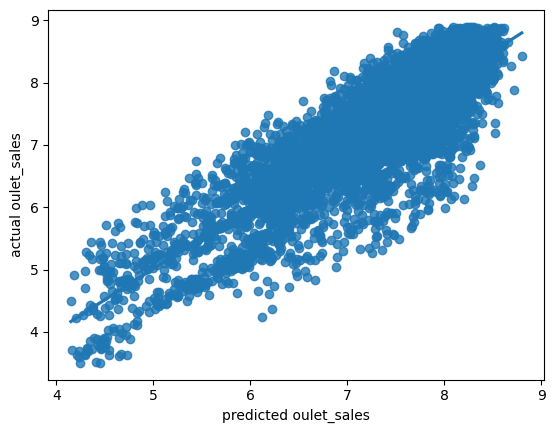

In [145]:
sns.regplot(x=pred_train,y=y_train)
plt.xlabel("predicted oulet_sales")
plt.ylabel("actual oulet_sales")

CROSS VALIDATION

In [146]:
from sklearn.model_selection import cross_val_score
cross_val_score(LinearRegression(),x,y)

array([0.70489349, 0.6960685 , 0.69830532, 0.70091001, 0.72679921])

In [147]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score


# Define the model
model = LinearRegression()

# Define hyperparameters to search
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Define scoring function (R^2 score)
scorer = make_scorer(r2_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring={'mse': 'neg_mean_squared_error', 'r2': scorer}, refit='r2')

# Perform grid search cross-validation
grid_search.fit(x, y)

# Print the best parameters found
print("Best parameters found:", grid_search.best_params_)

# Print the best estimator (model)
best_model = grid_search.best_estimator_
print("\nBest model:", best_model)

# Print the best cross-validation scores
best_mse_score = -grid_search.best_score_
print("\nBest cross-validation MSE:", best_mse_score)

# Extract R^2 scores from the grid search results
r2_scores = grid_search.cv_results_['mean_test_r2']
best_r2_score = np.max(r2_scores)
print("\nBest cross-validation R^2 score:", best_r2_score)


Best parameters found: {'fit_intercept': False, 'positive': True}

Best model: LinearRegression(fit_intercept=False, positive=True)

Best cross-validation MSE: -0.7054500082357835

Best cross-validation R^2 score: 0.7054500082357835


In [148]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# Define the polynomial regression model
model = LinearRegression()

# Define hyperparameters to search
param_grid = {
    'fit_intercept': [True, False],
    # 'normalize': [True, False]  # We remove the 'normalize' parameter
}

# Define polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(x)

# Define scoring functions (MSE and R^2 score)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring={'mse': mse_scorer, 'r2': r2_scorer}, refit='r2')

# Perform grid search cross-validation
grid_search.fit(X_poly, y)

# Print the best parameters found
print("Best parameters found:", grid_search.best_params_)

# Print the best estimator (model)
best_model = grid_search.best_estimator_
print("\nBest model:", best_model)

# Print the best cross-validation scores
best_mse_score = -grid_search.best_score_
print("\nBest cross-validation MSE:", best_mse_score)

# Extract R^2 scores from the grid search results
r2_scores = grid_search.cv_results_['mean_test_r2']
best_r2_score = np.max(r2_scores)
print("\nBest cross-validation R^2 score:", best_r2_score)


Best parameters found: {'fit_intercept': False}

Best model: LinearRegression(fit_intercept=False)

Best cross-validation MSE: -0.7146326298478577

Best cross-validation R^2 score: 0.7146326298478577
